#### Example API and Analysis Notebook

In [ ]:
from git import Repo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

Repo.clone_from("https://github.com/costquestassociates/cqazapi-pytools.git", "cqazapipytools")
!pip install -r cqazapipytools/requirements.txt

In [2]:
API_KEY = ""

if not API_KEY:
    try:
        with open('secrets.json', 'r') as f:
            secrets = json.load(f)
        API_KEY = secrets.get('fabric_api_key')
    except FileNotFoundError:
        API_KEY = None

if not API_KEY:
    raise RuntimeError("API key not found. Please fill in your API_KEY in the variable above.")

# Example 1: Fiber Coverage by Greenfield Cost to Build

### Use API to query Clarke County, Georgia

In [ ]:
from cqazapipytools import *

VINTAGE = '202412'
FIELDS = 'location_id,blockfips,bdc_fiber,fibergreenfieldpassinv'
COUNTY_FIPS = '13058' # Clarke County, Georgia
CHUNK_SIZE = 1000
LIMIT = None  # None returns all rows

with cqazapipytools(API_KEY, cachepath='cache.db') as cp:
    # Collect Fabric UUIDs inside the county
    county_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/counties?id={COUNTY_FIPS}', 'GET')
    uuids = cp.collect(VINTAGE, county_geojson)

    if LIMIT:
        uuids = uuids[:LIMIT]

    # Call Fabric bulk api, retrieve only desired fields
    endpoint = f'fabric/{VINTAGE}/bulk/locations?field={FIELDS}'
    results = cp.bulkApiAction(endpoint, 'POST', uuids, maxsize=CHUNK_SIZE)

    # Write to CSV 
    cp.csvWrite(f'county_{COUNTY_FIPS}_fabric.csv', results)

    # Show a quick sample
    print(f"Returned {len(results)} records")
    for r in results[:3]:
        print(r)

In [ ]:
results_df = pd.DataFrame(results)
results_df.drop('uuid', axis=1, inplace = True)
service_map = {3: "Unserved", 2: "Underserved", 1: "Served"}
results_df["service_level"] = results_df["bdc_fiber"].map(service_map).astype("category")
results_df.head()

### Quick Plotting

In [ ]:
df = results_df.copy()

min_val = df['fibergreenfieldpassinv'].min()
max_val = 5000
bins = np.arange(0, max_val + 1, 500)

# Create a bin label column (intervals)
df['inv_bin'] = pd.cut(df['fibergreenfieldpassinv'], bins=bins, include_lowest=True)

# Group and count by bin and service level
grouped = df.groupby(['inv_bin', 'service_level'], observed=True).size().unstack(fill_value=0)

# #Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
grouped.plot(kind='bar', stacked=True, ax=ax, width=0.8, colormap='tab20')

ax.set_xlabel('Fiber Greenfield Pass Investment (binned)', fontsize = 20)
ax.set_ylabel('BSL Count', fontsize = 20)
ax.set_title('Clarke County (Georgia) Fiber', fontsize = 20)
ax.legend(title='Service Level')

# Improve xlabels: show bin ranges nicely
ax.set_xticklabels([f'{np.abs(interval.left):.0f}–{interval.right:.0f}' for interval in grouped.index], rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Example 2: Competitive Provider Analysis

### Brookhaven, suburb of Atlanta

`SELECT DISTINCT SUBSTR(BlockFIPS, 1, 11)
  FROM read_parquet('*.parquet')
  WHERE City = 'BROOKHAVEN'
    AND State = 'GA';`

- Number of locations served by each Fiber provider (share of the market)
- Identify areas with few fiber providers (cheap to build), as potential opportunities
- Follium maps

In [3]:
from cqazapipytools import *

Brookhaven_tractFIPS = [
    '13089021101',
    '13089021103',
    '13089021104',
    '13089021219',
    '13089021220',
    '13089021221',
    '13089021222',
    '13089021405',
    '13089021410',
    '13089021411',
    '13089021412',
    '13089021415',
    '13089021416',
    '13089021417',
    '13089021418',
    '13089021419',
    '13089021420',
    '13089021421',
    '13089021607',
    '13121009409',
    '13121009410',
    '13121009607',
    '13121010115',
]

VINTAGE = '202412'
FIELDS = 'location_id,latitude,longitude,unit_count,blockfips,bdc_fiber,bdc_fiberproviders'
CHUNK_SIZE = 1000

with cqazapipytools(API_KEY, cachepath='cache.db') as cp:
    tract_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/tracts?id={Brookhaven_tractFIPS[0]}', 'GET')
    uuids = cp.collect(VINTAGE, tract_geojson)
    for fips in Brookhaven_tractFIPS[1:]:
        tract_geojson = cp.apiAction(f'geosvc/libgetgeo/tiger/2020/tracts?id={fips}', 'GET')
        uuids += cp.collect(VINTAGE, tract_geojson)

    # Call Fabric bulk api, retrieve only desired fields
    endpoint = f'fabric/{VINTAGE}/bulk/locations?field={FIELDS}'
    results = cp.bulkApiAction(endpoint, 'POST', uuids, maxsize=CHUNK_SIZE)

    # Show a quick sample
    print(f"Returned {len(results)} records")
    for r in results[:3]:
        print(r)

API request (1/0) to GET https://api.costquest.com/accountcontrol/listapis succeeded in 0.482s
API request (2/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021101 succeeded in 0.01s
API request (3/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.001s
API request (4/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021103 succeeded in 0.001s
API request (5/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.001s
API request (6/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021104 succeeded in 0.001s
API request (7/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.001s
API request (8/0) to CACHE https://api.costquest.com/geosvc/libgetgeo/tiger/2020/tracts?id=13089021219 succeeded in 0.001s
API request (9/0) to CACHE https://api.costquest.com/fabric/202412/collect2 succeeded in 0.001s
API request (10/0) to CACHE ht

#### Parse raw data

In [4]:
import re

def parse_providers(cell):
    """
    Convert a cell like 'Google Fiber(1) |AT&T(1) ' -> ['AT&T', 'Google Fiber']
    - Splits on '|'
    - Removes trailing counts like '(1)'
    - Strips whitespace
    - Normalizes duplicates
    - Returns [] for None/NaN/empty
    """
    if pd.isna(cell):
        return []

    # Split on '|'
    parts = [p.strip() for p in str(cell).split('|') if p.strip()]
    cleaned = []

    for p in parts:
        # Remove trailing count in parentheses, e.g., '(1)'
        p = re.sub(r'\(\d+\)\s*$', '', p).strip()
        if p:
            cleaned.append(p)

    return sorted(cleaned)

# Clean and explode provider list
results_df = pd.DataFrame(results)
results_df.drop('uuid', axis=1, inplace = True)
results_df['bdc_fiberproviders'] = results_df['bdc_fiberproviders'].apply(parse_providers)
results_df = results_df.explode("bdc_fiberproviders")

# Reorganize columns
columns = results_df.columns.tolist()
columns_ordered = ['location_id', 'latitude', 'longitude', 'unit_count']
[columns.remove(x) for x in columns_ordered]
results_df = results_df[columns_ordered + columns]

#### Make Map of Number of Fiber Providers at every location
(will take 30-60 seconds)

In [14]:
import os, zipfile, requests, folium
import geopandas as gpd

# Expect results_df with columns: location_id, latitude, longitude, bdc_fiberproviders (exploded to single provider/row)
df = results_df.dropna(subset=["latitude", "longitude"]).copy()
agg = (df.groupby(["location_id","latitude","longitude"])["bdc_fiberproviders"]
         .nunique().reset_index(name="unique_fiber_count"))

# Get Census tracts (national). For speed, swap to state-level zip: tl_2023_{STATEFP}_tract.zip
zip_path = "tl_2023_us_tract.zip"
url = "https://www2.census.gov/geo/tiger/TIGER2023/TRACT/tl_2023_13_tract.zip"
if not os.path.exists(zip_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(zip_path, "wb") as f:
            for c in r.iter_content(1024*1024): f.write(c)

with zipfile.ZipFile(zip_path) as z:
    shp = [n for n in z.namelist() if n.endswith(".shp")][0]
    tracts = gpd.read_file(f"zip://{os.path.abspath(zip_path)}!{shp}").to_crs(4326)

if not agg.empty:
    tracts = tracts.cx[
        agg["longitude"].min()-0.01 : agg["longitude"].max()+0.01,
        agg["latitude"].min()-0.01  : agg["latitude"].max()+0.01
    ]

follium_map = folium.Map(location=[agg["latitude"].median(), agg["longitude"].median()],
    zoom_start=13, tiles="cartodbpositron"
)

folium.GeoJson(
    tracts.to_json(),
    name="Census Tracts",
    style_function=lambda _: {"fillOpacity":0.05,"weight":0.5,"color":"#555"}
).add_to(follium_map)

def color(n):
    n = min(4, int(n))
    color_dict = {
        0: "#918d8c",
        1: "#1f77b4",
        2: "#2ca02c",
        3: "#ff7f0e",
        4: "#d62728"
    }
    return color_dict[n]

for _, r in agg.iterrows():
    folium.Circle(
        location=(r["latitude"], r["longitude"]),
        radius=5,
        color=color(r["unique_fiber_count"]),
        fill=True, fill_color=color(r["unique_fiber_count"]), fill_opacity=0.7,
        popup=folium.Popup(
            f"Location: {r['location_id']}<br>Providers: {r['unique_fiber_count']}", max_width=250),
        tooltip=f"{r['unique_fiber_count']} providers"
    ).add_to(follium_map)

legend_html = """
<div style="position:fixed;bottom:24px;left:24px;max-width:220px;background:#fff;border:1px solid #bbb;border-radius:8px;box-shadow:0 4px 12px rgba(0,0,0,.12);z-index:9999;font:14px/1.2 system-ui,Segoe UI,Roboto,Helvetica,Arial;padding:12px 14px;">
  <div style="font-weight:600;margin-bottom:8px;">Unique Fiber Providers</div>
  <div style="display:grid;grid-template-columns:auto 1fr;row-gap:6px;column-gap:8px;align-items:center;">
    <span style="width:12px;height:12px;background:#918d8c;border-radius:2px;opacity:.9;"></span><span>0</span>
    <span style="width:12px;height:12px;background:#1f77b4;border-radius:2px;opacity:.9;"></span><span>1</span>
    <span style="width:12px;height:12px;background:#2ca02c;border-radius:2px;opacity:.9;"></span><span>2</span>
    <span style="width:12px;height:12px;background:#ff7f0e;border-radius:2px;opacity:.9;"></span><span>3</span>
    <span style="width:12px;height:12px;background:#d62728;border-radius:2px;opacity:.9;"></span><span>4+</span>
  </div>
</div>
"""
follium_map.get_root().html.add_child(folium.Element(legend_html))

folium.LayerControl().add_to(follium_map)
follium_map.save("fiber_providers_map.html")

Try displaying the follium map in the jupyter notebook directly

In [ ]:
follium_map

#### Analyze total locations and units served by each Fiber provider

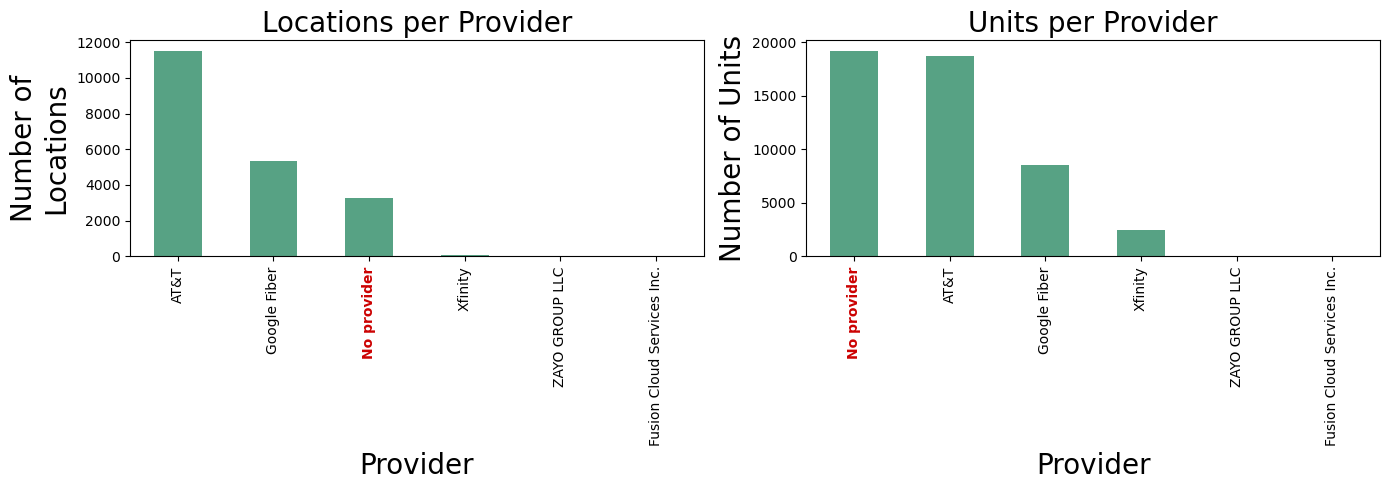

In [30]:
# Treat NaN as "No provider"
df = results_df.copy()
df["provider"] = df["bdc_fiberproviders"].fillna("No provider")

# Locations served per provider (unique locations)
locations_per_provider = (
    df.drop_duplicates(["location_id", "provider"])
      .groupby("provider")["location_id"]
      .nunique()
      .sort_values(ascending=False)
)

# Units served per provider (sum unit_count across unique location-provider pairs)
units_per_provider = (
    df.drop_duplicates(["location_id", "provider"])
      .groupby("provider")["unit_count"]
      .sum()
      .sort_values(ascending=False)
)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
locations_per_provider.plot(kind="bar", ax=axes[0], color="#57A284")
axes[0].set_title("Locations per Provider", fontsize = 20)
axes[0].set_xlabel("Provider", fontsize = 20)
axes[0].set_ylabel("Number of\nLocations", fontsize = 20)
axes[0].tick_params(axis='x', rotation=90)

units_per_provider.plot(kind="bar", ax=axes[1], color="#57A284")
axes[1].set_title("Units per Provider", fontsize = 20)
axes[1].set_xlabel("Provider", fontsize = 20)
axes[1].set_ylabel("Number of Units", fontsize = 20)
axes[1].tick_params(axis='x', rotation=90)

# Distinguish the "No provider" tick label on each subplot
for ax in axes:
    for tick in ax.get_xticklabels():
        if tick.get_text() == "No provider":
            tick.set_fontweight("bold")
            tick.set_color("#CC0202")

plt.tight_layout()
plt.show()

#### Analyze who the top providers are competing with most in their footprint

In [ ]:
# Copy and normalize providers
df = results_df.copy()
df["provider"] = df["bdc_fiberproviders"].fillna("No provider")

# Build per-location provider sets (unique providers per location)
loc_providers = (
    df.drop_duplicates(["location_id", "provider"])
      .groupby("location_id")["provider"]
      .apply(lambda s: tuple(sorted(set(p for p in s if p != "No provider"))))
      .reset_index(name="provider_set")
)

# Filter to AT&T and Google Fiber footprints
targets = ["AT&T", "Google Fiber"]
footprints = {}
for t in targets:
    # locations where target is present
    locs_t = loc_providers[loc_providers["provider_set"].apply(lambda s: t in s)].copy()
    # competitor tuple excluding the target
    locs_t["competitors"] = locs_t["provider_set"].apply(lambda s: tuple(p for p in s if p != t))
    footprints[t] = locs_t

# Helper: attach units per location (sum units per location)
units_per_loc = (df.groupby("location_id")["unit_count"].sum().rename("units"))

# Compute breakdowns: counts of locations and sum of units by competitor combo
breakdowns = {}
for t, fp in footprints.items():
    tmp = fp.merge(units_per_loc, left_on="location_id", right_index=True, how="left")
    # Label for readability
    def label_competitors(comp):
        if len(comp) == 0:
            return "Sole provider"
        return " + ".join(comp)
    tmp["competition_label"] = tmp["competitors"].apply(label_competitors)
    by_combo = tmp.groupby("competition_label").agg(
        locations=("location_id", "nunique"),
        units=("units", "sum")
    ).sort_values(["locations", "units"], ascending=False)
    breakdowns[t] = by_combo

for t in targets:
    print(f"\n=== {t}: Competition breakdown (summary) ===")
    print(breakdowns[t])


=== AT&T: Competition breakdown (summary) ===
                        locations  units
competition_label                       
Sole provider                6902  12324
Google Fiber                 4596  11354
Xfinity                        15    952
ZAYO GROUP LLC                  4     50
Google Fiber + Xfinity          2    618

=== Google Fiber: Competition breakdown (summary) ===
                   locations  units
competition_label                  
AT&T                    4596  11354
Sole provider            742   2455
AT&T + Xfinity             2    618
Xfinity                    2    460
ZAYO GROUP LLC             1      2


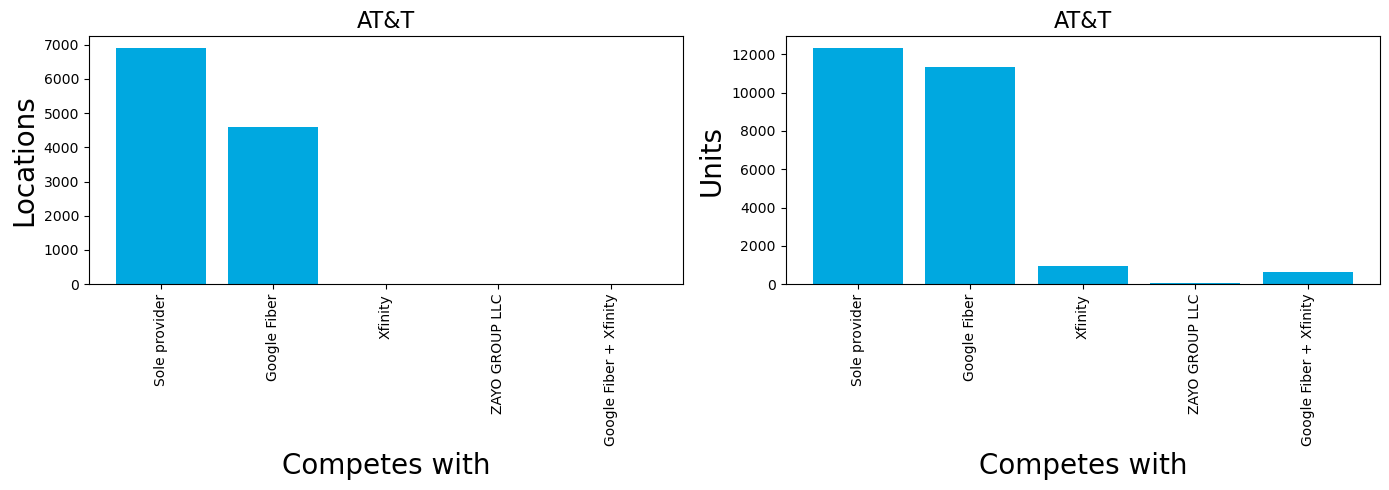

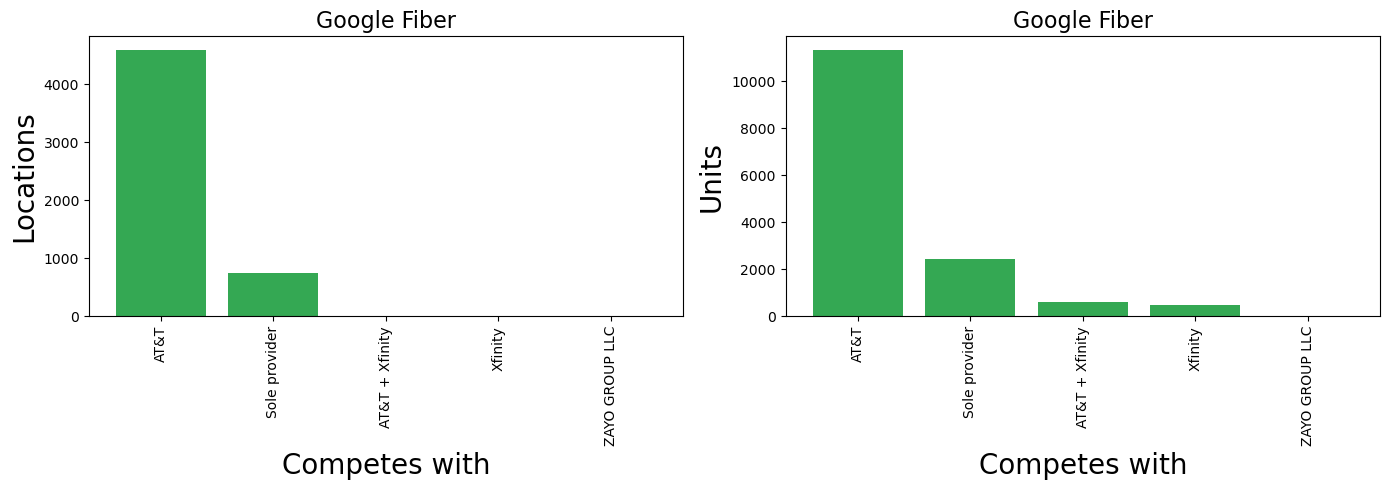

In [35]:
# Bar plots for each target
import matplotlib.pyplot as plt

color_arr = ["#00A8E0", "#34A853"]
for key, t in enumerate(targets):
    summary = breakdowns[t].copy()
    summary = summary.sort_values("locations", ascending=False)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
    axes[0].bar(summary.index, summary["locations"], color=color_arr[key])
    axes[0].set_title(f"{t}", fontsize=16)
    axes[0].set_ylabel("Locations", fontsize = 20)
    axes[0].tick_params(axis="x", rotation=90)

    axes[1].bar(summary.index, summary["units"], color=color_arr[key])
    axes[1].set_title(f"{t}", fontsize=16)
    axes[1].set_ylabel("Units", fontsize = 20)
    axes[1].tick_params(axis="x", rotation=90)

    axes[0].set_xlabel('Competes with', fontsize = 20)
    axes[1].set_xlabel('Competes with', fontsize = 20)
    
    # axes[0].set_yscale('log')
    # axes[1].set_yscale('log')

    plt.tight_layout()
    plt.show()

#### Conclusions

- AT&T and Google Fiber are the only "big" fiber players in Brookhaven, with Xfinity serving a small number of high unit count locations. 
Zayo and Fusion Cloud have negligible footprints here.
- AT&T's footprint holds a substantial amount of "sole provider" status, while Google Fiber is primarily competing with AT&T.
- Xfinity fiber serves a low number of locations but a large number of units (probably apartment buildings)